## CNN-UNET socat


In [1]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras

import os
tf.random.set_seed(42)


sys.path.insert(0, '../../src')
from utils import df_to_xarray,read_xarray,inverse_scale_image, get_point_prediction

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-01-30 13:44:42.552365: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [4]:
def preprocess_images(dir_name,num="001",socat=False):
    
    chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2 = read_xarray(dir_name,num)
    
    if socat:

        chl_images = preprocess_image_reduced(chl.Chl_socat.data)
        mld_images = preprocess_image_reduced(mld.MLD_socat.data)
        sss_images = preprocess_image_reduced(sss.SSS_socat.data)
        sst_images = preprocess_image_reduced(sst.SST_socat.data)
        xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
        pco2_images = preprocess_image_reduced(pco2.pCO2.data)
    else:
        chl_images = preprocess_image_reduced(chl.Chl.data)
        mld_images = preprocess_image_reduced(mld.MLD.data)
        sss_images = preprocess_image_reduced(sss.SSS.data)
        sst_images = preprocess_image_reduced(sst.SST.data)
        xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
        pco2_images = preprocess_image_reduced(pco2.pCO2.data)
    
    X = np.dstack((chl_images, mld_images, sss_images, sst_images, xco2_images))
    X = X.reshape((421,180,360,5),order='F')

    return X, pco2_images



In [5]:
dir_name="../../data/data1"
val_dir_name="../../data/data2"


data,pco2 = preprocess_images(dir_name,socat=True)
test_data,test_pco2 = preprocess_images(val_dir_name,"035",True)

In [7]:
INPUT_SHAPE=data[0].shape
OUTPUT_SHAPE=pco2[0].shape

INPUT_SHAPE

(180, 360, 5)

In [8]:
import tensorflow.keras.backend as kb
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[y_true != 0]
    y_true = y_true[y_true != 0]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true), axis=-1))

In [9]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=5,activation='elu',
                        padding="SAME")


base_model = keras.models.Sequential([
    DefaultConv2D(filters=64, input_shape=INPUT_SHAPE),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=3), #pool size 3 > pool size 2
    keras.layers.Dropout(0.3),# drop out at the end of the deepest

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),


    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=64),    
    DefaultConv2D(filters=2),
    DefaultConv2D(filters=1,kernel_size=1),
    keras.layers.Reshape(OUTPUT_SHAPE)
   
])


## BEST SO FAR ##

base_model.summary()

2022-01-30 13:46:37.850931: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-30 13:46:37.868715: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-30 13:46:37.929996: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.49GiB deviceMemoryBandwidth: 581.23GiB/s
2022-01-30 13:46:37.930175: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-30 13:46:37.980406: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-30 13:46:37.980469: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-0

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 360, 64)      8064      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 360, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 120, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 120, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 120, 128)      204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 120, 128)      409728    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 180, 360, 128)     0

In [10]:
myLearnRate=0.001
custom_opt = tf.keras.optimizers.Adam(learning_rate=myLearnRate)
base_model.compile(loss=custom_rmse, optimizer=custom_opt, metrics=["mean_squared_error"])

In [13]:
model_path="../../models/base_model/socat_unet_model.h5"
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

#batch size 24, 32, 64 not as good
# batch size 16 the best
history = base_model.fit(data,pco2, epochs=100, validation_data=(test_data,test_pco2),workers=-1,batch_size=16,callbacks=callbacks)




2022-01-30 13:47:57.526104: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-30 13:47:57.548902: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2900000000 Hz


Epoch 1/100


2022-01-30 13:47:58.453677: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-01-30 13:48:11.940966: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-30 13:48:12.998581: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


27/27 [==============================] - 27s 320ms/step - loss: 70.0189 - mean_squared_error: 5999.0768 - val_loss: 17.1419 - val_mean_squared_error: 1573.0161
Epoch 2/100
27/27 [==============================] - 6s 232ms/step - loss: 20.2434 - mean_squared_error: 1799.8044 - val_loss: 18.2326 - val_mean_squared_error: 2070.9333
Epoch 3/100
27/27 [==============================] - 6s 232ms/step - loss: 16.0819 - mean_squared_error: 1879.3217 - val_loss: 14.4009 - val_mean_squared_error: 1838.0997
Epoch 4/100
27/27 [==============================] - 6s 233ms/step - loss: 14.7719 - mean_squared_error: 1890.2525 - val_loss: 14.1820 - val_mean_squared_error: 1859.9943
Epoch 5/100
27/27 [==============================] - 6s 232ms/step - loss: 14.2895 - mean_squared_error: 1922.2305 - val_loss: 13.5852 - val_mean_squared_error: 1992.2008
Epoch 6/100
27/27 [==============================] - 6s 232ms/step - loss: 13.6643 - mean_squared_error: 2031.9390 - val_loss: 14.5553 - val_mean_squared_er

In [18]:
best_model = tf.keras.models.load_model('../../models/base_model/socat_unet_model.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image=best_model.predict(data,verbose=1)

14/14 [==============================] - 2s 111ms/step


In [19]:
predicted_image[pco2==0]=0.0

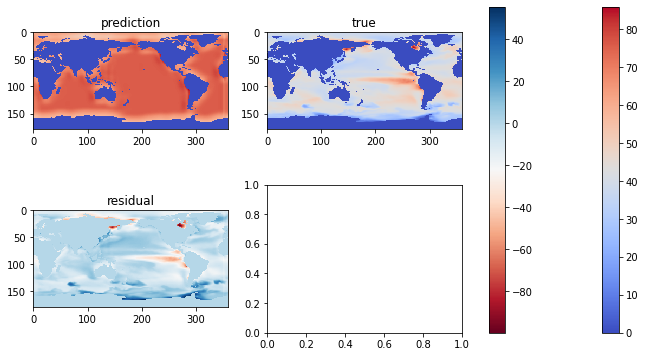

In [22]:
figure, axis = plt.subplots(2, 2,figsize=(12, 6))


img=axis[0][0].imshow(np.flipud(predicted_image[0]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(pco2[0]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true")

diff=np.flipud(np.squeeze(predicted_image[0]-pco2[0]))
img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest")
axis[1][0].set_title("residual")
plt.colorbar(img2,ax=axis)


plt.show()

